In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [2]:
!ls

Data_Challenge_A%2FB_Problem.pdf  test_results.csv
solution2.ipynb			  user_table.csv


In [3]:
userframe = pd.read_csv('user_table.csv')
testframe = pd.read_csv('test_results.csv')

In [4]:
userframe.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [5]:
testframe.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [6]:

#Drop into sql syntax 
from pandasql import sqldf 
pysqldf = lambda q: sqldf(q, globals()) 

converoldpricequery = """Select price, sum(converted) as converts, count(converted) as viewed
from  testframe 
group by price;"""

In [7]:
test_table = pysqldf(converoldpricequery)

In [8]:
test_table['rate'] = test_table['converts']/test_table['viewed']
test_table

,price,converts,viewed,rate
0,39,4031,202672,0.019889
1,59,1777,114128,0.015570


In [9]:
test_table['expect_revenue'] = test_table['rate'] * test_table['price']
test_table

,price,converts,viewed,rate,expect_revenue
0,39,4031,202672,0.019889,0.775682
1,59,1777,114128,0.015570,0.918644


In [10]:
converoldpricequery = """select *
from  testframe 
left join userframe on userframe.user_id = testframe.user_id"""

In [11]:
combinedtable = pysqldf(converoldpricequery)

In [12]:
combinedtable.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,user_id,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,604839.0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,624057.0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,317970.0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,685636.0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,820854.0,Fishers,USA,39.95,-86.02


In [13]:
combinedtable.describe()

,user_id,test,price,converted,user_id,lat,long
count,316800.000000,316800.000000,316800.000000,316800.000000,275616.000000,275616.000000,275616.000000
mean,499281.341840,0.360079,46.205051,0.018333,499245.801521,37.111680,-93.981772
std,288591.154044,0.480024,9.601487,0.134154,288533.458944,5.209627,18.086486
min,3.000000,0.000000,39.000000,0.000000,3.000000,19.700000,-157.800000
25%,249525.750000,0.000000,39.000000,0.000000,249544.500000,33.660000,-112.200000
50%,499021.500000,0.000000,39.000000,0.000000,498861.000000,37.740000,-88.930000
75%,749025.500000,1.000000,59.000000,0.000000,748856.500000,40.700000,-78.910000
max,1000000.000000,1.000000,59.000000,1.000000,999999.000000,61.180000,30.310000


In [14]:


converoldpricequery = """Select price, source, device, operative_system, sum(converted) as converts, count(converted) as marks
from  testframe 
group by price, source, device, operative_system;"""

In [15]:
newtest_table = pysqldf(converoldpricequery)

In [16]:
test_table

,price,converts,viewed,rate,expect_revenue
0,39,4031,202672,0.019889,0.775682
1,59,1777,114128,0.015570,0.918644


In [17]:
newtest_table['source'].unique()

array([u'ads-bing', u'ads-google', u'ads-yahoo', u'ads_facebook',
       u'ads_other', u'direct_traffic', u'friend_referral', u'seo-bing',
       u'seo-google', u'seo-other', u'seo-yahoo', u'seo_facebook'], dtype=object)

In [18]:
lowcost = testframe.loc[(testframe.price==39) & (testframe.test==0)]
highcost = testframe.loc[(testframe.price == 59) & (testframe.test==1)]

# Resample the lowcost and highcost frames in order to get a grasp on what the expectation of the value of each view is at each of the different prices.

In [19]:
def build_distribution(inputframe, column, nsamples, samplesize):
    conversionrate = np.zeros(nsamples)
    expectrevenue = conversionrate
    for i in range(nsamples):
        samp = inputframe.sample(n=samplesize)
        conversionrate[i] = samp['converted'].sum()/np.float64(samplesize)
    expectrevenue = conversionrate * np.float64(inputframe['price'].median())
    return conversionrate, expectrevenue

cl_rate, rl_rate = build_distribution(lowcost, 'converted', 1000, 500)
ch_rate, rh_rate = build_distribution(highcost, 'converted', 1000, 500)
print np.mean(cl_rate), np.mean(rl_rate), np.mean(ch_rate), np.mean(rh_rate)

0.020224 0.788736 0.015456 0.911904


In [20]:
from scipy import stats

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


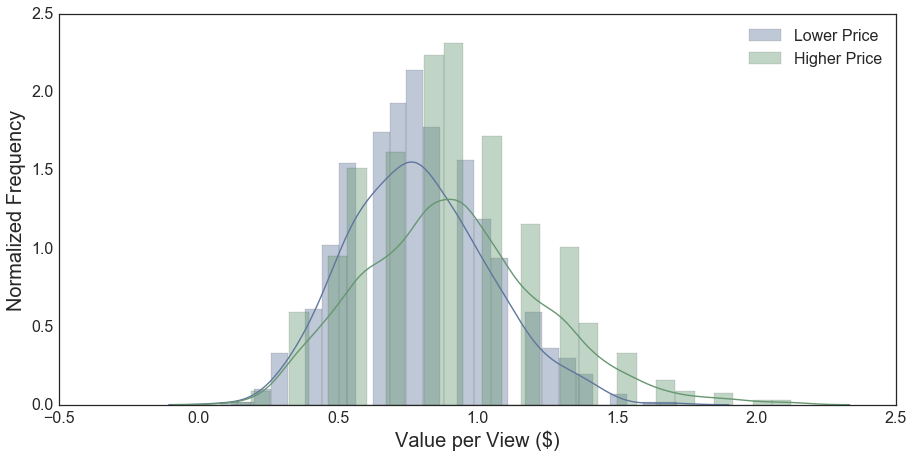

In [21]:
sns.set_palette("deep", desat=.6)
sns.set_context("paper",font_scale=2)
sns.set_style("white")
mats = dict()
mats[0] = rl_rate
mats[1] = rh_rate
fig, ax = plt.subplots(figsize=(15,7),sharey=True)
legendlabels = ['Lower Price', 'Higher Price']
binsize = np.linspace(0, 1.8, 0.1)
for a in range(len(legendlabels)):
    sns.distplot(mats[a], kde=True,
                 label= legendlabels[a])
ax.set_xlabel('Value per View ($)', fontsize= 20)
ax.set_ylabel('Normalized Frequency', fontsize=20)
ax.legend()

## The plot of the two distributions suggests that raising the price for all consumers will result in higher revenue.  A t-test will make this conclusion more robust.


In [22]:
print np.mean(rl_rate), np.std(rl_rate)

0.788736 0.251898412667


In [23]:
print np.mean(rh_rate), np.std(rh_rate)

0.911904 0.321255211295


In [24]:
import statsmodels.stats.api as sms
cm = sms.CompareMeans(sms.DescrStatsW(rl_rate), sms.DescrStatsW(rh_rate))
print cm.tconfint_diff(usevar='unequal')

(-0.14849922609042321, -0.097836773909576902)


/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### The result of the t-test is that we can reject the null hypothesis that the revenue generated from the lower price is >= to that from the higher price and that the 95% confidence interval  for the revenue for each viewer that sees the higher price is 6-11 cents higher than a user that sees the lower price

# What other Factors may be influential in conversion rates?

In [25]:
from pandas import datetime
testframe['timestamp'].head()

0    2015-05-08 03:38:34
1    2015-05-10 21:08:46
2    2015-04-04 15:01:23
3    2015-05-07 07:26:01
4    2015-05-24 11:04:40
Name: timestamp, dtype: object

In [26]:
testframe['timestamp'] = pd.to_datetime(testframe['timestamp'], format='%Y-%m-%d %H:%M:%S', errors='ignore')

In [27]:
testframe['timestamp'].max()

'2015-05-31 23:59:45'

In [28]:
testframe['timestamp'].min()

'2015-03-02 00:04:12'

In [30]:
converoldpricequery = """Select price, 
source, device, operative_system, 
sum(converted) as converts, count(converted) as viewed, test
from  testframe 
group by price, source, device, operative_system;"""
newtest_table = pysqldf(converoldpricequery)
newtest_table['conversionrate'] = newtest_table['converts']/np.float64(newtest_table['viewed'])
newtest_table['customervalue'] = newtest_table['conversionrate'] * newtest_table['price']
newtest_table.head(), newtest_table.tail()

(   price    source  device operative_system  converts  viewed  test  \
 0     39  ads-bing  mobile          android        45    3458     0   
 1     39  ads-bing  mobile              iOS        69    4506     0   
 2     39  ads-bing  mobile            other         7     754     0   
 3     39  ads-bing     web            linux         0     152     0   
 4     39  ads-bing     web              mac        13    1126     0   
 
    conversionrate  customervalue  
 0        0.013013       0.507519  
 1        0.015313       0.597204  
 2        0.009284       0.362069  
 3        0.000000       0.000000  
 4        0.011545       0.450266  ,
      price        source  device operative_system  converts  viewed  test  \
 158     59  seo_facebook  mobile            other         5     411     1   
 159     59  seo_facebook     web            linux         0     136     1   
 160     59  seo_facebook     web              mac         9     523     1   
 161     59  seo_facebook     web    

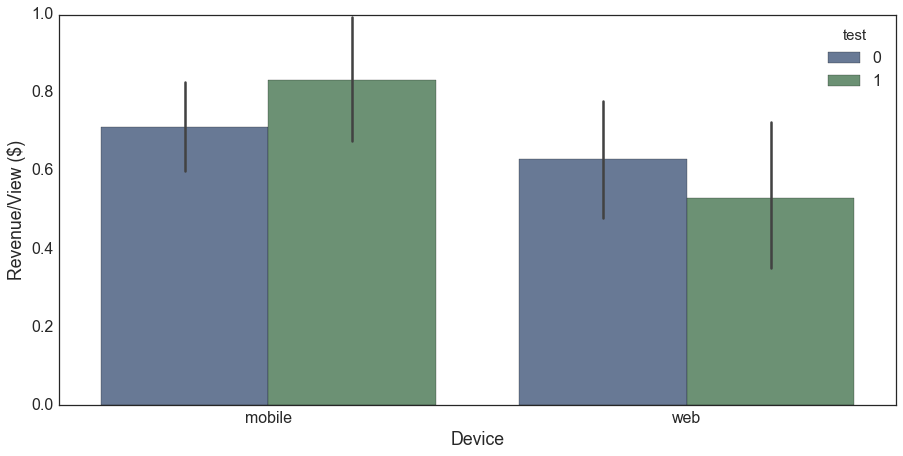

In [31]:
fig, ax = plt.subplots(figsize=(15,7),sharey=True)
sns.barplot(x='device', y = 'customervalue', hue='test', data = newtest_table)
ax.set_xlabel('Device')
ax.set_ylabel('Revenue/View ($)')

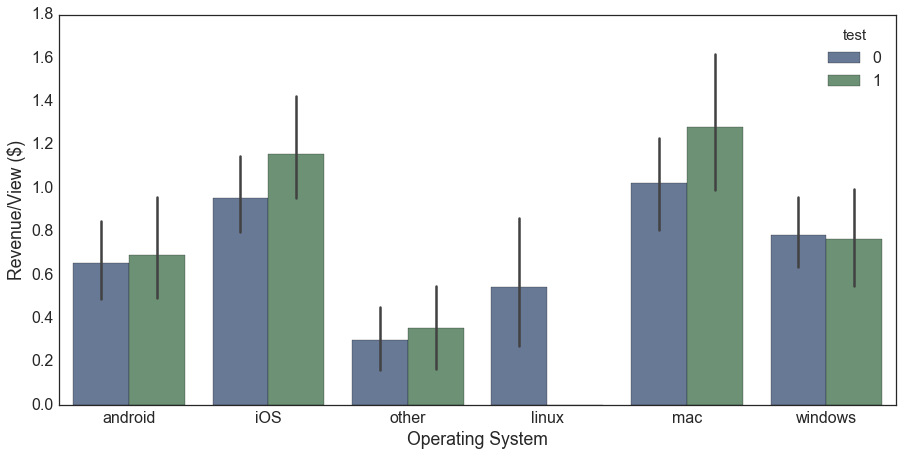

In [32]:
fig, ax = plt.subplots(figsize=(15,7),sharey=True)
sns.barplot(x='operative_system', y = 'customervalue', hue='test', data = newtest_table)
ax.set_xlabel('Operating System')
ax.set_ylabel('Revenue/View ($)')

## Interesting that the Apple product users seem to be much more profitable at the higher price than the users of other operating systems.  Let's check out the Windows and Android Users

In [33]:
lowcost = testframe.loc[(testframe.price==39) & (testframe.test==0) & 
                        (testframe.operative_system != 'mac') & 
                        (testframe.operative_system !='iOS') &
                       (testframe.operative_system !='linux') &
                       (testframe.operative_system !='other')]
highcost = testframe.loc[(testframe.price == 59) & 
                         (testframe.test==1) & 
                         (testframe.operative_system != 'mac') & 
                         (testframe.operative_system !='iOS')&
                        (testframe.operative_system !='linux') &
                        (testframe.operative_system !='other')]
cl_rate_NOAP, rl_rate_NOAP = build_distribution(lowcost, 'converted', 1000, 500)
ch_rate_NOAP, rh_rate_NOAP = build_distribution(highcost, 'converted', 333, 1000)
print np.mean(cl_rate_NOAP), np.mean(rl_rate_NOAP), np.mean(ch_rate_NOAP), np.mean(rh_rate_NOAP)


0.017706 0.690534 0.0131321321321 0.774795795796


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


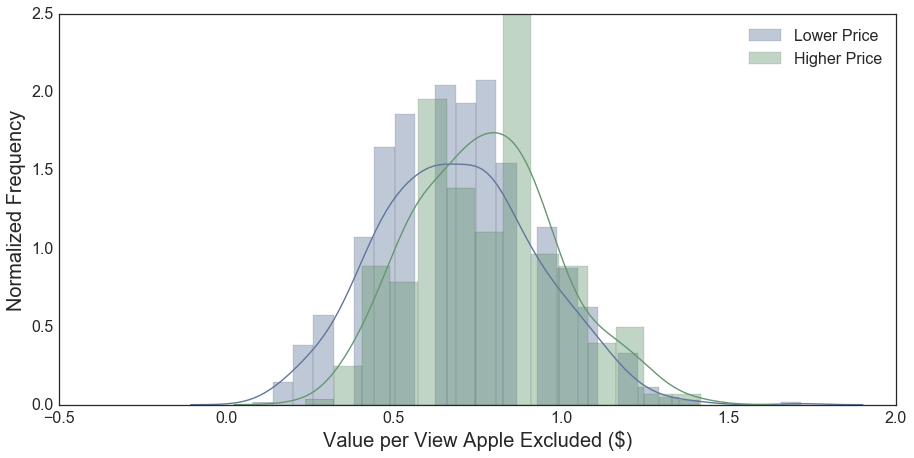

In [34]:
sns.set_palette("deep", desat=.6)
sns.set_context("paper",font_scale=2)
sns.set_style("white")
mats = dict()
mats[0] = rl_rate_NOAP
mats[1] = rh_rate_NOAP
fig, ax = plt.subplots(figsize=(15,7),sharey=True)
legendlabels = ['Lower Price', 'Higher Price']
binsize = np.linspace(0, 1.8, 0.1)
for a in range(len(legendlabels)):
    sns.distplot(mats[a], kde=True,
                 label= legendlabels[a])
ax.set_xlabel('Value per View Apple Excluded ($)', fontsize= 20)
ax.set_ylabel('Normalized Frequency', fontsize=20)
ax.legend()

In [35]:
stats.ttest_ind(rl_rate_NOAP, rh_rate_NOAP, axis=0, equal_var = False)
cm = sms.CompareMeans(sms.DescrStatsW(rl_rate_NOAP), sms.DescrStatsW(rh_rate_NOAP))
print cm.tconfint_diff(usevar='unequal')

(-0.11158305902518909, -0.056940532566402614)


## Even without the Apple users, you still make a little bit more per viewer with the higher price. 

## It would be wise to advertise more to Windows and Android users rather than the Apple users because the Apple users are already very profitable at the higher price.

In [36]:
lowcost = testframe.loc[(testframe.price==39) & (testframe.test==0) & 
                        (testframe.operative_system != 'windows') & 
                        (testframe.operative_system !='android') &
                       (testframe.operative_system !='linux') &
                       (testframe.operative_system !='other')]
highcost = testframe.loc[(testframe.price == 59) & 
                         (testframe.test==1) & 
                         (testframe.operative_system != 'windows') & 
                         (testframe.operative_system !='android')&
                        (testframe.operative_system !='linux') &
                        (testframe.operative_system !='other')]
cl_rate_AP, rl_rate_AP = build_distribution(lowcost, 'converted', 1000, 500)
ch_rate_AP, rh_rate_AP = build_distribution(highcost, 'converted', 333, 1000)
print np.mean(cl_rate_AP), np.mean(rl_rate_AP), np.mean(ch_rate_AP), np.mean(rh_rate_AP)

0.023728 0.925392 0.0198768768769 1.17273573574


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


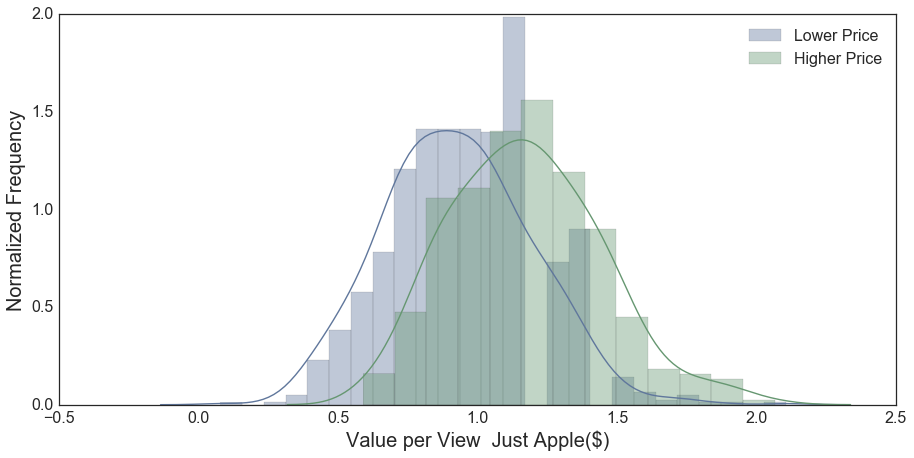

In [37]:
sns.set_palette("deep", desat=.6)
sns.set_context("paper",font_scale=2)
sns.set_style("white")
mats = dict()
mats[0] = rl_rate_AP
mats[1] = rh_rate_AP
fig, ax = plt.subplots(figsize=(15,7),sharey=True)
legendlabels = ['Lower Price', 'Higher Price']
binsize = np.linspace(0, 1.8, 0.1)
for a in range(len(legendlabels)):
    sns.distplot(mats[a], kde=True,
                 label= legendlabels[a])
ax.set_xlabel('Value per View  Just Apple($)', fontsize= 20)
ax.set_ylabel('Normalized Frequency', fontsize=20)
ax.legend()

In [38]:
stats.ttest_ind(rl_rate_AP, rh_rate_AP, axis=0, equal_var = False)
cm = sms.CompareMeans(sms.DescrStatsW(rl_rate_AP), sms.DescrStatsW(rh_rate_AP))
print cm.tconfint_diff(usevar='unequal')

(-0.28116522771914376, -0.2135222437523282)


# How long should the test be run to come up with this result?


##  This experiment has been going on for nearly three months.  Do a similar calculation as above, but only draw the sample from days that occur before a specified date.  Find out how long it is until you start seeing significant separation in the  distributions 